# Trabajo Práctico 3: Detectando atributos de personas.

## Integrantes: Cravero, Ulises y Pautasso, L. Nicolás.
## Tema: CS:GO Professional Matches.

### Imports y configs

In [3]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG19

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# para descargar los datasets desde kaggle
import opendatasets as od

# para dividir el dataset
import os
import shutil
import pandas as pd
import random
import time

### Descarga de datos

#### Descargamos el dataset desde Kaggle:

In [ ]:
# descargamos el dataset correspondiente desde Kaggle
od.download("https://www.kaggle.com/datasets/jessicali9530/celeba-dataset")

#### Fusionamos los datasets que nos serviran para identificar a que conjunto pertenece cada registro y si representa una imagen con barba o no

In [4]:
# cargamos ambos datasets
list_partition = pd.read_csv("./celeba-dataset/list_eval_partition.csv")
list_attribs = pd.read_csv("./celeba-dataset/list_attr_celeba.csv")

# merge en base a la columna 'image_id'
list_partition_and_attribs = pd.merge(list_partition, list_attribs[['image_id', 'No_Beard']], on='image_id', how='inner')

# formateamos
list_partition_and_attribs.columns = list_partition_and_attribs.columns.str.lower()

# convertimos de -1 y 1 a 0 y 1 (va a ser útil para armar el path despues)
list_partition_and_attribs['no_beard'] = np.where(list_partition_and_attribs['no_beard'] == 1, 1, 0)

list_partition_and_attribs.sample(3)

,image_id,partition,no_beard
29416,029417.jpg,0,1
113456,113457.jpg,0,1
118679,118680.jpg,0,1


#### Dividimos las imágenes en directorios dependiendo a que conjunto de datos pertenece

In [5]:
# variables auxiliares para crear los directorios
partitions_names = ['train', 'validation', 'test']
group_names = ['yes_beard', 'no_beard']
# rutas de los directorios que contienen las imágenes
directorios = ['./partitions/train', './partitions/validation', './partitions/test']

In [6]:
# ruta del directorio donde se descargaron las imágenes
directory = "./celeba-dataset/img_align_celeba/img_align_celeba"

# creamos las carpetas de destino
output_directory = "./partitions"
os.makedirs(output_directory, exist_ok=True)

# filtramos y movemos las imágenes a las carpetas correspondientes 
# (partitions_name[0] = train, partitions_name[1] = validation y partitions_name[2] = test)
# (groups_name[0] = yes_beard y groups_name[1] = no_beard)
for index, row in list_partition_and_attribs.iterrows():
    image_id = row['image_id']
    partition = row['partition']
    attribute = row['no_beard']
    source_path = os.path.join(directory, f"{image_id}")
    destination_path = os.path.join(output_directory, partitions_names[partition], group_names[attribute], f"{image_id}")
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    shutil.copyfile(source_path, destination_path)

### Análisis exploratorio sobre el conjunto de datos

#### Muestreo y caracteristicas de las imágenes:

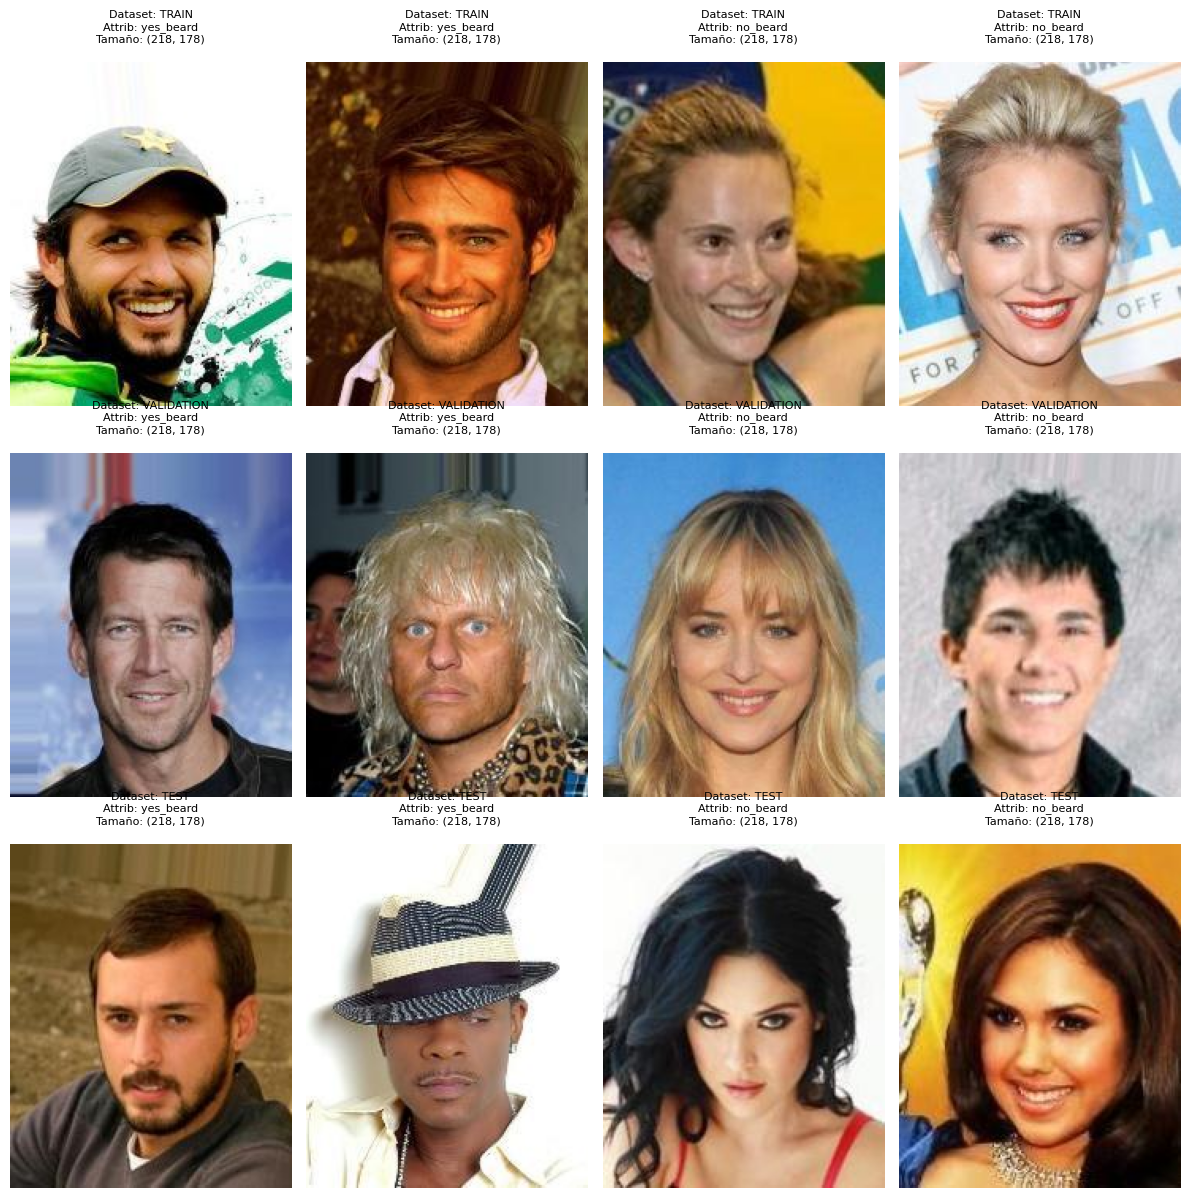

In [6]:
# Mostrar una cuadrícula de 3x4
fig, axs = plt.subplots(3, 4, figsize=(12, 12))

# Iterar sobre los directorios
for i, directorio in enumerate(directorios):
    dir_yes_beard = os.path.join(directorio, group_names[0])
    dir_no_beard = os.path.join(directorio, group_names[1])
    # Elegir cuatro imágenes aleatorias dentro de los subdirectorios
    list_dir_yes_beard = os.listdir(dir_yes_beard)
    list_dir_no_beard = os.listdir(dir_no_beard)
    muestras_yes = random.sample(list_dir_yes_beard, 2)
    muestras_no = random.sample(list_dir_no_beard, 2)
    muestras = muestras_yes + muestras_no
    # Iterar sobre las muestras y mostrar las imágenes
    for j, muestra in enumerate(muestras):
        #nos fijamos a donde pertenece la muestra
        conjunto = group_names[0] if muestra in muestras_yes else group_names[1]
        ruta_imagen = os.path.join(directorio, conjunto, muestra)       
        # Leer la imagen y mostrarla
        img = plt.imread(ruta_imagen)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        # Obtener características de la imagen
        tamano = img.shape[:2]
        formato = muestra.split('.')[-1].upper()
        tipo = img.dtype
        axs[i, j].set_title(f"Dataset: {partitions_names[i].upper()}\nAttrib: {conjunto}\nTamaño: {tamano}\n", fontsize=8)
    
    
# Ajustar el espacio entre las imágenes
plt.tight_layout()

# Mostrar el gráfico con las imágenes
plt.show()

#### Cantidad de imagenes por conjunto, cantidad de imagenes por categoria/conjunto y distribución de la variable de salida ('no_beard') por conjunto:

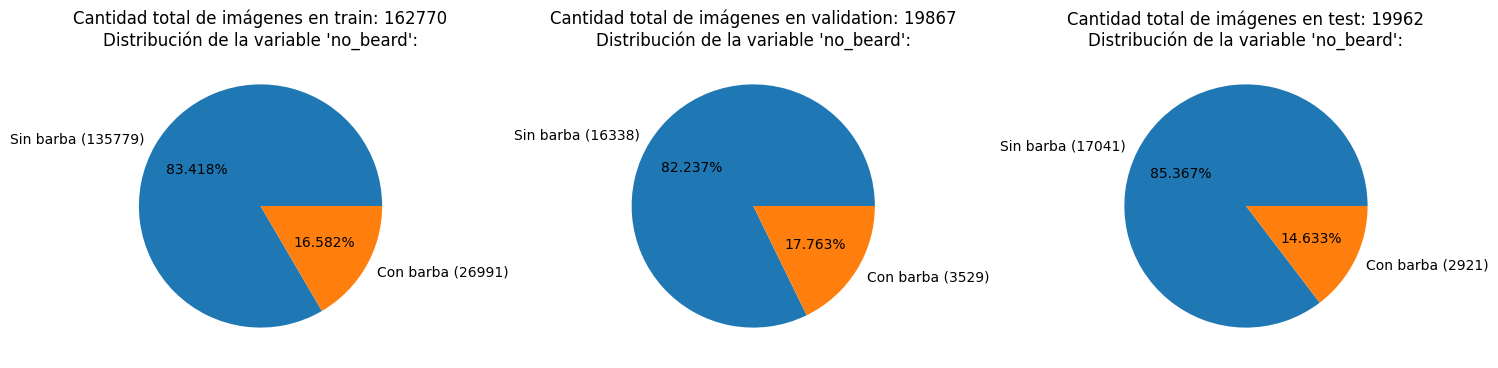

In [7]:
# 1 fila y 3 columnas

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
for index, _ in enumerate(partitions_names):
    ax = axs[index]
    partition_data = list_partition_and_attribs[list_partition_and_attribs['partition'] == index]
    no_beard = (partition_data['no_beard'] == 1).sum()
    yes_beard = (partition_data['no_beard'] == 0).sum()

    ax.pie([no_beard, yes_beard], labels=[f"Sin barba ({no_beard})", f"Con barba ({yes_beard})"], autopct='%1.3f%%')
    ax.set_title(f"Cantidad total de imágenes en {partitions_names[index]}: {no_beard + yes_beard}\nDistribución de la variable 'no_beard':")

plt.tight_layout()
plt.show()
    

### Machine learning

#### Cargamos las imágenes de cada dataset en variables

In [22]:
# tamaño de procesado
size = 64

# Data generator set without augmentation
train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)
test_data = ImageDataGenerator(rescale=1/255)

# Load images without augmentation
train_set = train_data.flow_from_directory(directorios[0], target_size=(size, size), class_mode='binary')
validation_set = validation_data.flow_from_directory(directorios[1], target_size=(size, size), class_mode='binary')
test_set = test_data.flow_from_directory(directorios[2], target_size=(size, size), class_mode='binary')


Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Found 19962 images belonging to 2 classes.


#### Visualizamos algunos ejemplos a modo de ver la forma que tendran las imagenes al procesarlas

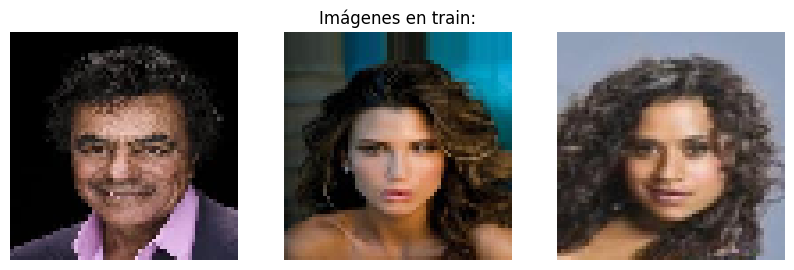

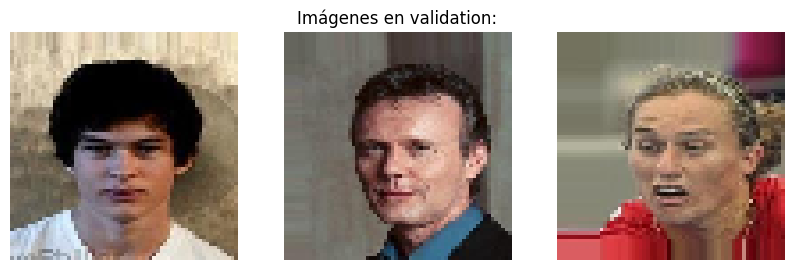

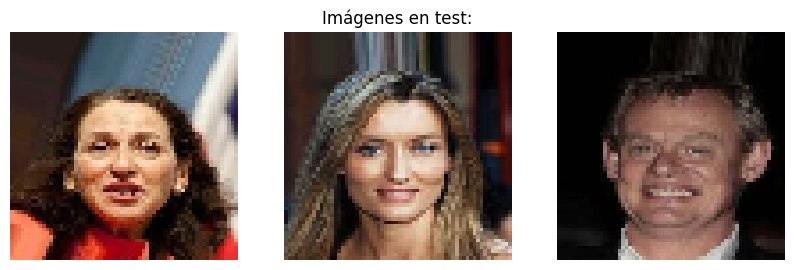

In [23]:
def sample_images(dataset, titulo):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.title(titulo) if i == 1 else plt.title('')
        plt.axis("off")
    
sample_images(train_set, 'Imágenes en train:')
sample_images(validation_set, 'Imágenes en validation:')
sample_images(test_set, 'Imágenes en test:')

#### Inicializamos los modelos a entrenar

In [27]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (size, size, 3)

# instanciamos el callback
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

#### MLP simple

In [28]:
model_mlp = Sequential([
    Flatten(input_shape=input_shape),
    Dense(200, activation ="relu"),
    Dropout(0.25),
    Dense(1, activation='sigmoid'),
])

model_mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_mlp.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 12288)             0         
                                                                 
 dense_12 (Dense)            (None, 200)               2457800   
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 201       
                                                                 
Total params: 2458001 (9.38 MB)
Trainable params: 2458001 (9.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
history_mlp = model_mlp.fit(
    train_set,
    epochs=10,
    batch_size=50000,
    validation_data=validation_set,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 85s 17ms/step - loss: 0.3528 - accuracy: 0.8342 - val_loss: 0.2956 - val_accuracy: 0.8224
Epoch 2/10
5087/5087 [==============================] - 86s 17ms/step - loss: 0.3010 - accuracy: 0.8698 - val_loss: 0.2668 - val_accuracy: 0.8956
Epoch 3/10
5087/5087 [==============================] - 86s 17ms/step - loss: 0.2871 - accuracy: 0.8792 - val_loss: 0.2692 - val_accuracy: 0.8880
Epoch 4/10
5087/5087 [==============================] - 86s 17ms/step - loss: 0.2816 - accuracy: 0.8835 - val_loss: 0.2576 - val_accuracy: 0.8969
Epoch 5/10
5087/5087 [==============================] - 86s 17ms/step - loss: 0.2774 - accuracy: 0.8848 - val_loss: 0.2604 - val_accuracy: 0.8982
Epoch 6/10
5087/5087 [==============================] - 86s 17ms/step - loss: 0.2734 - accuracy: 0.8867 - val_loss: 0.2521 - val_accuracy: 0.9008
Epoch 7/10
5087/5087 [==============================] - 86s 17ms/step - loss: 0.2710 - accuracy: 0.8887 - val_loss: 0.2548 -

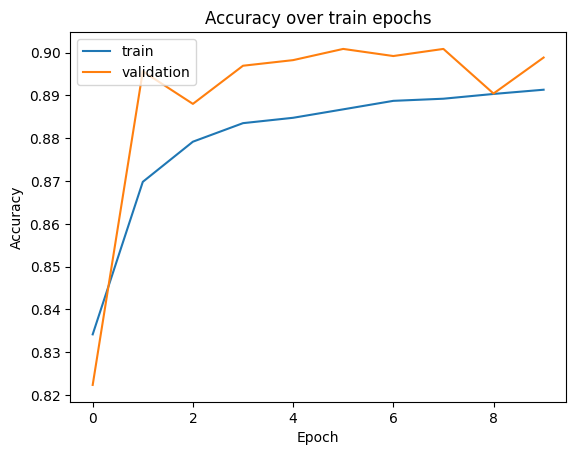

In [32]:
plt.plot(history_mlp.history['accuracy'], label='train')
plt.plot(history_mlp.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
### la conclusion aca es que relu anda mejor que tanh y que con dropout no se si mejora mucho pero evitamos overfit

#### Convolucional

In [41]:
model_conv = Sequential([
    Convolution2D(input_shape=input_shape, filters=15, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=15, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(10, activation='tanh'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

model_conv.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_conv.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 15)        735       
                                                                 
 dropout_5 (Dropout)         (None, 61, 61, 15)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 15)        3615      
                                                                 
 dropout_6 (Dropout)         (None, 58, 58, 15)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 15)        0         
 D)                                                              
                                                                 
 flatten_7 (Flatten)         (None, 2940)              0         
                                                      

In [42]:
history_conv = model_conv.fit(
    train_set,
    epochs=10,
    batch_size=50000,
    validation_data=validation_set,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 240s 47ms/step - loss: 0.2745 - accuracy: 0.8871 - val_loss: 0.2247 - val_accuracy: 0.9059
Epoch 2/10
5087/5087 [==============================] - 247s 48ms/step - loss: 0.2254 - accuracy: 0.9070 - val_loss: 0.2201 - val_accuracy: 0.9089
Epoch 3/10
5087/5087 [==============================] - 254s 50ms/step - loss: 0.2156 - accuracy: 0.9114 - val_loss: 0.1976 - val_accuracy: 0.9195
Epoch 4/10
5087/5087 [==============================] - 258s 51ms/step - loss: 0.2109 - accuracy: 0.9126 - val_loss: 0.1989 - val_accuracy: 0.9197
Epoch 5/10
5087/5087 [==============================] - 240s 47ms/step - loss: 0.2076 - accuracy: 0.9144 - val_loss: 0.1974 - val_accuracy: 0.9175
Epoch 6/10
5087/5087 [==============================] - 254s 50ms/step - loss: 0.2037 - accuracy: 0.9160 - val_loss: 0.1960 - val_accuracy: 0.9197
Epoch 7/10
5087/5087 [==============================] - 253s 50ms/step - loss: 0.2024 - accuracy: 0.9164 - val_loss: 0

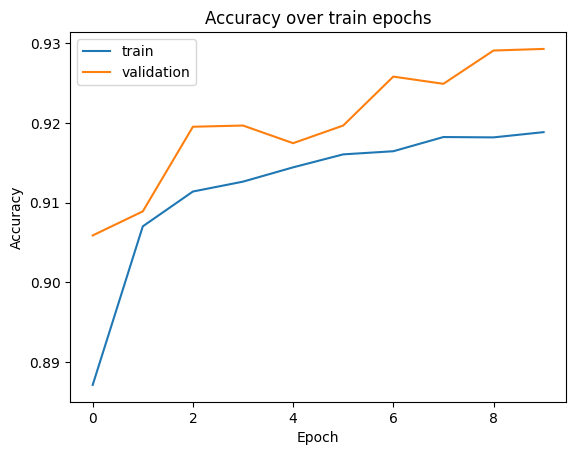

In [45]:
plt.plot(history_conv.history['accuracy'], label='train')
plt.plot(history_conv.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### Convolucional usando convoluciones ya entrenadas de VGG19

In [49]:
pretrained_model = VGG19(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_conv_fitted = Sequential([
    pretrained_model,

    Flatten(),

    Dense(250 , activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

model_conv_fitted.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_conv_fitted.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_23 (Dense)            (None, 250)               512250    
                                                                 
 dropout_8 (Dropout)         (None, 250)               0         
                                                                 
 dense_24 (Dense)            (None, 1)                 251       
                                                                 
Total params: 20536885 (78.34 MB)
Trainable params: 512501 (1.96 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [51]:
history_conv_fitted = model_conv_fitted.fit(
    train_set,
    epochs=10,
    batch_size=50000,
    validation_data=validation_set,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 1551s 305ms/step - loss: 0.3330 - accuracy: 0.8460 - val_loss: 0.3322 - val_accuracy: 0.8449
Epoch 2/10
5087/5087 [==============================] - 1577s 310ms/step - loss: 0.3251 - accuracy: 0.8493 - val_loss: 0.3345 - val_accuracy: 0.8440
Epoch 3/10
5087/5087 [==============================] - 1591s 313ms/step - loss: 0.3210 - accuracy: 0.8511 - val_loss: 0.3315 - val_accuracy: 0.8435
Epoch 4/10
5087/5087 [==============================] - 1599s 314ms/step - loss: 0.3169 - accuracy: 0.8523 - val_loss: 0.3263 - val_accuracy: 0.8473
Epoch 5/10
5087/5087 [==============================] - 1968s 387ms/step - loss: 0.3138 - accuracy: 0.8538 - val_loss: 0.3284 - val_accuracy: 0.8479
Epoch 6/10
5087/5087 [==============================] - 2749s 541ms/step - loss: 0.3109 - accuracy: 0.8546 - val_loss: 0.3215 - val_accuracy: 0.8508
Epoch 7/10
5087/5087 [==============================] - 2109s 415ms/step - loss: 0.3082 - accuracy: 0.8568

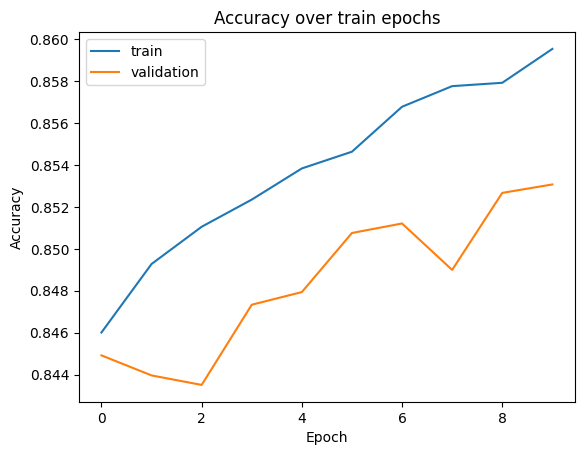

In [52]:
plt.plot(history_conv_fitted.history['accuracy'], label='train')
plt.plot(history_conv_fitted.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Aumentación de datos:

In [37]:
images_reader_aum = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    brightness_range=(1, 2),
    horizontal_flip=True
)

# Data generator set with augmentation
train_data_aum = images_reader_aum
validation_data_aum = images_reader_aum
test_data_aum = images_reader_aum

# Load images with augmentation
train_set_aum = train_data_aum.flow_from_directory(directorios[0], target_size=(size, size), class_mode='binary')
validation_set_aum = validation_data_aum.flow_from_directory(directorios[1], target_size=(size, size), class_mode='binary')
test_set_aum = test_data_aum.flow_from_directory(directorios[2], target_size=(size, size), class_mode='binary')

Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Found 19962 images belonging to 2 classes.


#### Visualizamos algunos ejemplos a modo de ver la forma que tendran las imagenes al procesarlas

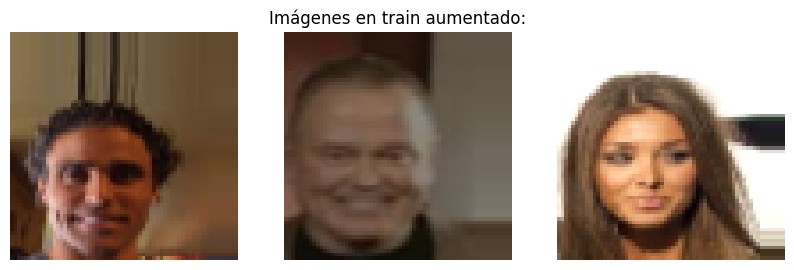

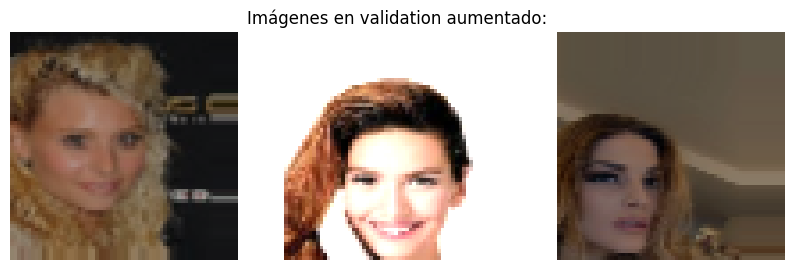

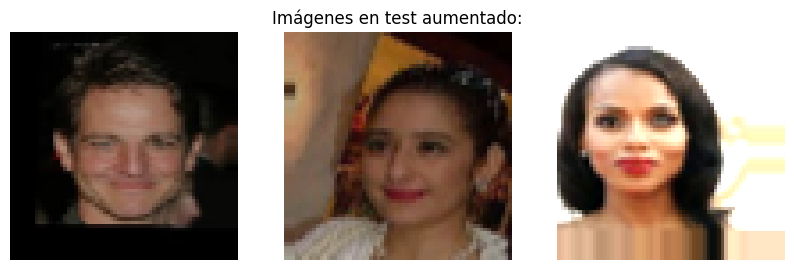

In [38]:
def sample_images(dataset, titulo):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.title(titulo) if i == 1 else plt.title('')
        plt.axis("off")
    
sample_images(train_set_aum, 'Imágenes en train aumentado:')
sample_images(validation_set_aum, 'Imágenes en validation aumentado:')
sample_images(test_set_aum, 'Imágenes en test aumentado:')

In [ ]:
### ACA VER CUAL ANDA MEJOR Y ENTRENARLO